In [7]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
from sklearn import decomposition
# import P
import os
# import openCV as 

In [8]:
def return_list_of_data(bpt = 2000,n_components=2,split_percent=70):
    data_dir = os.getcwd()+'\\'
    lis_folders = ['AbdomenCT','BreastMRI','ChestCT','CXR','Hand','HeadCT']
    X = []
    cur_class = 0
    for folder in lis_folders:
        i=0
        lis_files = os.listdir(data_dir+folder+'\.')
        im = []
        for files in lis_files:
            i+=1
            if(i==bpt+1):
                break
            img = '\\'.join([data_dir,folder,files])
            image = plt.imread(img)
            im.append(image.flatten().reshape(-1,1))
        im_np = np.array(im)[:,:,0]
        im_np = np.append(im_np,cur_class*np.ones((im_np.shape[0],1)),axis=1)
        cur_class+=1
        X.append(im_np)

    X_data_all = X[0]
    for x in X[1:]: 
        X_data_all = np.append(X_data_all,x,axis=0)
    
    np.random.shuffle(X_data_all)
    
    X_,y_ = X_data_all[:,:-1] , X_data_all[:,-1].reshape(-1,1)

    datasize = X_.shape[0]

    split_point = split_percent//10

    X_train = X_[:(datasize*split_point)//10,:]
    y_train = y_[:(datasize*split_point)//10,:]
    X_test = X_[(datasize*split_point)//10:,:]
    y_test = y_[(datasize*split_point)//10:,:]
    
    pca = decomposition.PCA(n_components)

    pca.fit(X_train)
    X_train_pca = np.zeros((X_train.shape[0],n_components))
    X_test_pca = np.zeros((X_test.shape[0],n_components))
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return(X_train_pca,y_train,X_test_pca,y_test)

In [14]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_train = X[0]
for x in X[1:]: 
    X_train = np.append(X_train,x,axis=0)
X_pca = X_train
pca.fit(X_pca[:,:-1])
X_pca[:,-3:-1] = pca.transform(X_pca[:,:-1])
print(X_pca.shape)

(6000, 4097)


In [2]:
def import_dataset(X_pcaa,split_percent = 70):
    
    X = X_pca[:,:-1]
    y = X_pca[:,-1:]
    datasize = X.shape[0]

    split_point = split_percent//10

    X_train = X[:(datasize*split_point)//10,:]
    y_train = y[:(datasize*split_point)//10,:]
    X_test = X[(datasize*split_point)//10:,:]
    y_test = y[(datasize*split_point)//10:,:]

    return(X_train,X_test,y_train,y_test)

In [5]:
print(X_pca[:30,:])

[[ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ... -2.15522006e+03
  -2.55347135e+02  5.00000000e+00]
 [ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ...  1.39401019e+03
  -9.79441910e+02  0.00000000e+00]
 [ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ... -4.64042573e+03
  -6.36189159e+02  1.00000000e+00]
 ...
 [ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ...  2.41926290e+03
  -1.36915402e+03  2.00000000e+00]
 [ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ... -1.88145859e+03
   2.92220210e+03  4.00000000e+00]
 [ 1.01000000e+02  1.01000000e+02  1.01000000e+02 ... -4.23623512e+03
  -1.42555466e+03  1.00000000e+00]]


In [17]:
def feature_scaling(X_train):
    training_size = X_train.shape[0]
    X_mean = np.sum(X_train,axis=0) / training_size
    X_var = np.sqrt(np.sum((np.square(X_train-X_mean)),axis=0)/training_size)
    X_train_reg = (X_train - X_mean) / X_var

    return (X_mean,X_var,X_train_reg)


In [29]:
def KNN(X_train,y_train,X_test,y_test,k_num,feat_scal=False):

    num_class = 6
    test_size = X_test.shape[0]
    train_size = X_train.shape[0]
    # print(X_train.shape)
    # print(X_test.shape)
    if feat_scal:
        X_m,X_v,X_r = feature_scaling(X_train)
        X_test_reg = (X_test-X_m)/X_v
    else:
        X_r = X_train
        X_test_reg = X_test
    
    y_pred = []
    
    for i in range(test_size):
        sample_X = X_test_reg[i:i+1,:]
        sample_y = y_test[i,:]
        dist_vec = np.sqrt(np.sum(np.square(X_r-sample_X),axis=1))
        dist_vec = dist_vec.reshape((train_size,1))

        d = np.column_stack((dist_vec[:,:],y_train[:,0]))
        # print(d)

        sorted_dist = d[np.argsort(d[:, 0])]
        y_val_vector = sorted_dist[:k_num,1].reshape(-1,1)
        class_sizes = []
        for j in range(num_class):
            num = y_val_vector[ y_val_vector[:,0]==j ].shape[0]
            class_sizes.append([num,j])
        class_sizes.sort(reverse=True)
        y_pred.append(class_sizes[0][1])   
    
    y_pred = np.array(y_pred).reshape(-1,1)

    # print(y_pred.shape)
    return y_pred
    
        



In [30]:
def accuracy(y_pred,y_test):

    # y_pred = y_pred.reshape(-1,1)
    print('MSE LOSS')
    mse_loss = np.sum(np.square((y_test-y_pred)),axis=0) / y_test.shape[0]
    print(mse_loss)
    print('............................................................................')
    print('MAE LOSS')
    mae_loss = np.sum(np.abs((y_test-y_pred)),axis=0) / y_test.shape[0]
    print(mae_loss)
    # print('............................................................................')

In [49]:
def accuracy(y_pred,y_test):

    test_size = y_test.shape[0]

    y_pred = y_pred.reshape((y_pred.shape[0],1))
    acc = y_test[ y_pred[:,0] == y_test[:,0] ].shape[0] * 100 / test_size 
    print('Accuracy: {}'.format( acc  ))
    return acc

In [50]:
def confusion_matrix(y_pred,y_test):
    cm = np.zeros((6,6))
    for i in range(y_pred.shape[0]):
        cm[y_test[i,0].astype(int),y_pred[i,0]]+=1
    return cm

In [60]:
al = []

for i in range(1,20):
    X_train_pca,y_train,X_test_pca,y_test = return_list_of_data(bpt=1000,n_components=i)
    print('model run initiated...')
    y_pred = KNN(X_train_pca,y_train,X_test_pca,y_test,3,False)
    print('model run completed')
    acc = accuracy(y_pred,y_test)
    al.append(acc)

model run initiated...
model run completed
Accuracy: 81.22222222222223
model run initiated...
model run completed
Accuracy: 98.22222222222223
model run initiated...
model run completed
Accuracy: 99.27777777777777
model run initiated...
model run completed
Accuracy: 99.38888888888889
model run initiated...
model run completed
Accuracy: 99.44444444444444
model run initiated...
model run completed
Accuracy: 99.5
model run initiated...
model run completed
Accuracy: 99.5
model run initiated...
model run completed
Accuracy: 99.44444444444444
model run initiated...
model run completed
Accuracy: 99.22222222222223
model run initiated...
model run completed
Accuracy: 99.33333333333333
model run initiated...
model run completed
Accuracy: 99.33333333333333
model run initiated...
model run completed
Accuracy: 99.55555555555556
model run initiated...
model run completed
Accuracy: 99.44444444444444
model run initiated...
model run completed
Accuracy: 99.55555555555556
model run initiated...
model run

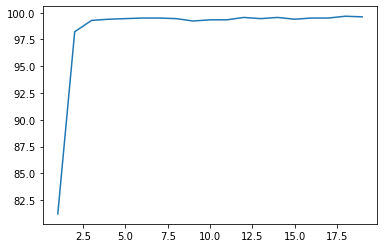

In [62]:
x = list(range(1,20))
plt.plot(x,al)

In [45]:
print(confusion_matrix(y_pred,y_test).astype(int))

[[3009    0    0    0    0    0]
 [   0 2747    0    0    0    0]
 [   0    0 3008    0    0    0]
 [   0    0    2 2990   31    2]
 [  17    2    5    1 2871   47]
 [   0    0    0    0    0 2955]]


In [72]:
def parsen_window(X_train,y_train,X_test,y_test,window_size,feat_scal=False,num_class=6):

    test_size = X_test.shape[0]
    train_size = X_train.shape[0]
    if feat_scal:
        X_m,X_v,X_r = feature_scaling(X_train)
        X_test_reg = (X_test-X_m)/X_v
    else:
        X_r = X_train
        X_test_reg = X_test
    
    y_pred = []
    # print(y_pred)
    for i in range(test_size):
        sample_X = X_test_reg[i:i+1,:]
        sample_y = y_test[i,:]
        dist_vec = np.sqrt(np.sum(np.square(X_r-sample_X),axis=1))
        dist_vec = dist_vec.reshape((train_size,1))
        
        hyp_cube = y_train[dist_vec[:,0]<=window_size,0].reshape(-1,1)

        class_sizes = []
        for j in range(num_class):
            num = hyp_cube[ hyp_cube[:,0]==j ].shape[0]
            class_sizes.append([num,j])
        class_sizes.sort(reverse=True)
        y_pred.append(class_sizes[0][1])
        
        
    y_pred = np.array(y_pred).reshape(-1,1)
    return y_pred
        

In [90]:
gr = []

In [91]:
for g in range(1,10):
    al = []
    X_train_pca,y_train,X_test_pca,y_test = return_list_of_data(bpt=1000,n_components=g)
    for i in range(1,200):
        print('model run initiated...')
        y_pred_Parsen = parsen_window(X_train_pca,y_train,X_test_pca,y_test,i,False)
        print('model run completed')
        acc = accuracy(y_pred_Parsen,y_test)
        al.append(acc)
    gr.append(al)

acy: 55.05555555555556
model run initiated...
model run completed
Accuracy: 55.27777777777778
model run initiated...
model run completed
Accuracy: 55.388888888888886
model run initiated...
model run completed
Accuracy: 55.55555555555556
model run initiated...
model run completed
Accuracy: 55.94444444444444
model run initiated...
model run completed
Accuracy: 56.0
model run initiated...
model run completed
Accuracy: 56.111111111111114
model run initiated...
model run completed
Accuracy: 56.166666666666664
model run initiated...
model run completed
Accuracy: 56.388888888888886
model run initiated...
model run completed
Accuracy: 56.666666666666664
model run initiated...
model run completed
Accuracy: 56.666666666666664
model run initiated...
model run completed
Accuracy: 56.72222222222222
model run initiated...
model run completed
Accuracy: 56.77777777777778
model run initiated...
model run completed
Accuracy: 56.888888888888886
model run initiated...
model run completed
Accuracy: 57.0555

97.05555555555556


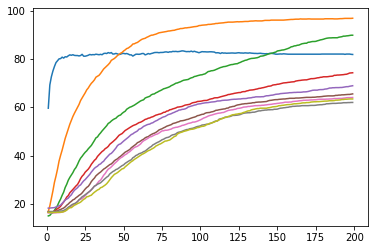

In [112]:
x = list(range(1,200))
print(gr[1][-1])
for g in gr:
    plt.plot(x,g)